In [1]:
import os
import numpy as np
import torch
import pandas as pd

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

from typing import Optional,Callable,Any
from os import DirEntry

from torchvision.transforms import Lambda
from torch.utils.data import DataLoader

from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights

import torch.optim as optim

import time

from matplotlib.colors import LinearSegmentedColormap
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
train_on_gpu = torch.cuda.is_available()
print(device, train_on_gpu)

cuda True


In [3]:
data_dir='/home/max/Documents/Datasets/digit-recognizer/'

In [4]:
seed = 13
torch.manual_seed(seed)
np.random.seed(seed)

In [5]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    image = image.numpy().transpose((1, 2, 0))
    
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [40]:
import torch.nn.functional as F

class DigitDataset(datasets.VisionDataset):
    def __init__(
        self,
        root: str,
        file: str,
        is_train = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        
        self.img_size = 28
        self.is_train = is_train
        self.num_classes = 10
        
        self.transform = transform
        self.target_transform = target_transform
        
        self.__make_datasat__(os.path.join(root, file))
        
    def __getitem__(self, index: int) -> Any:
        sample = self.X[index].reshape(self.img_size, self.img_size)
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        if self.target_transform is not None:
            sample = self.target_transform(sample)   

        if self.is_train == True:
            target = F.one_hot(torch.tensor(self.Y[index]), self.num_classes)
            target = target.to(float)
            return sample, target
        
        return sample

    def __len__(self) -> int:
        return self.X.shape[0]
    
    
    def __make_datasat__(self, path):
        df = pd.read_csv(path).to_numpy()
        
        if self.is_train:
            self.Y = df[:,0]
            self.X = df[:,1:]
        else:
            self.X = df
            self.Y = np.array(df.shape[0])
        

In [22]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, x.shape[1], x.shape[2])),
    
    transforms.Resize(224),
#     transforms.RandomChoice([
#         transforms.RandomPerspective(),
#         transforms.RandomResizedCrop(224, scale=(0.5, 1)),
#         transforms.RandomRotation(20)
#     ]),
    
    
    transforms.Lambda(lambda x: x.to(torch.float)),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
    
    
])


dc = DigitDataset(data_dir, 'train.csv', transform=train_transform)
train_dc, val_dc = torch.utils.data.random_split(dc, [40000, 2000], generator=torch.Generator().manual_seed(seed))

# train_dc = dc 

test_dc = DigitDataset(data_dir, 'test.csv', transform=train_transform, is_train=False)

In [8]:
# transforms.RandomResizedCrop?
# resNet50_transforms = ResNet50_Weights.DEFAULT.transforms()
# resNet50_transforms
#     img = F.resize(img, self.resize_size, interpolation=self.interpolation)
#     img = F.center_crop(img, self.crop_size)
#     if not isinstance(img, Tensor):
#        img = F.pil_to_tensor(img)
#     img = F.convert_image_dtype(img, torch.float)
#     img = F.normalize(img, mean=self.mean, std=self.std)

42000


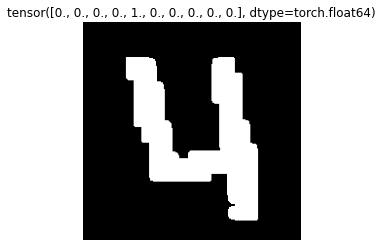

In [9]:
# train_dc.imgshow(544)
# train_dc.imgshow(11)
# train.__len__()

print(train_dc.__len__())
image, label = train_dc.__getitem__(3)
imshow(image, title=label);

In [37]:
test_dc.imgshow(0)
test_dc.__len__()

AttributeError: 'DigitDataset' object has no attribute 'imgshow'

In [23]:
batch_size=128

train_dataloader = DataLoader(train_dc, batch_size=batch_size, shuffle=True, num_workers=14)
val_dataloader = DataLoader(val_dc, batch_size=batch_size, shuffle=True, num_workers=14)

test_dataloader = DataLoader(test_dc, batch_size=batch_size, shuffle=False)


In [12]:
train_features, train_labels = next(iter(train_dataloader))

In [13]:
print(train_labels.shape)

torch.Size([64, 10])


In [14]:
train_features.shape

torch.Size([64, 3, 28, 28])

In [15]:
train_features[0, 0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 110,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [11]:
# model = resnet50(weights=ResNet50_Weights.DEFAULT)
model = resnet18(weights=ResNet18_Weights.DEFAULT)

In [17]:
# torch.save(model.state_dict(), './mnist_36_.pt')
# torch.save(model.state_dict(), './mnist_993.pt')
# torch.save(model.state_dict(), './mnist_tmp.pt')
torch.save(model.state_dict(), './mnist_full.pt')
# model.load_state_dict(torch.load('./mnist_tmp.pt'))
# model

In [21]:
# for param in model.conv1.parameters():
#     param.requires_grad = False

# for param in model.bn1.parameters():
#     param.requires_grad = False

# for param in model.relu.parameters():
#     param.requires_grad = False

# for param in model.maxpool.parameters():
#     param.requires_grad = False
    
# for param in model.layer1.parameters():
#     param.requires_grad = False
    
# for param in model.layer2.parameters():
#     param.requires_grad = False
    
# for param in model.layer3.parameters():
#     param.requires_grad = False
    
# for param in model.layer4.parameters():
#     param.requires_grad = False

# for param in model.avgpool.parameters():
#     param.requires_grad = False
    
    
# self.fc = nn.Linear(512 * block.expansion, num_classes)

for param in model.parameters():
    param.requires_grad = False
    
    

In [12]:
import torch.nn as nn

num_classes = 10

# classifier = nn.Sequential(
#     nn.Linear(2048, 1024),
#     nn.ReLU(),
#     nn.Linear(1024, num_classes),
#     nn.LogSoftmax(dim=1)
# )


classifier = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes),
    nn.LogSoftmax(dim=1)
)

model.fc = classifier

In [14]:
torch.cuda.empty_cache()

In [14]:
class NetTrainer:
    def __init__(self, model, criterion, optimizer):
        
        self.model = model
        self.criterion = criterion 
        self.optimizer = optimizer
        
        self.train_losses = [] 
        self.eval_losses = []
        
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.train_on_gpu = torch.cuda.is_available()
        
        print("Train on: ", device, train_on_gpu)
        
        self.model.to(device)
        
        
    def train(self, epochs, train_dataloader, val_dataloader):
        self.train_len = len(train_dataloader)
        
        val_msg = ""
        
        for e in range(epochs):
            model.train()
            running_loss = 0
            tic = time.perf_counter()
            i = 0
            for data, target in train_dataloader:
                i += 1

                if self.train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                optimizer.zero_grad()

                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                running_loss += loss.cpu().item()
                
#                 break;
            else: 
                if val_dataloader is not None:
                    val_loss, val_accuracy = self.evaluate(val_dataloader)
                    self.eval_losses.append(val_loss)

                    val_msg = "Val Loss: {:.3f}.. ".format(self.eval_losses[-1]) + " Val Accuracy: {:.3f}".format(val_accuracy)

            self.train_losses.append(running_loss/self.train_len)
            toc = time.perf_counter()
            
            duration = " {:.2f} min".format( (toc - tic)/60 )
            
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(self.train_losses[-1]),
                  val_msg,
                 duration)
            
        if val_dataloader is not None:
            self.print_val_summary()
    
    
    def print_val_summary(self):
        for i in range(self.num_classes):
            if self.class_total[i] > 0:
                print('Val Accuracy of %5s: %2d%% (%2d/%2d)' % (
                    self.classes[i], 100 * self.class_correct[i] / self.class_total[i],
                    np.sum(self.class_correct[i]), np.sum(self.class_total[i])))
            else:
                print('Val Accuracy of %5s: N/A (no training examples)' % (self.classes[i]))
        
        
        
    def evaluate(self, test_dataloader):
        test_len = len(test_dataloader)

        test_loss = 0
        accuracy = 0
        test_losses = []
        
        self.num_classes = 10 #TODO: change it
        self.class_correct = list(0. for i in range(self.num_classes))
        self.class_total = list(0. for i in range(self.num_classes))
        self.classes = list(i for i in range(self.num_classes))

        with torch.no_grad():
            model.eval()
            for data, target in test_dataloader:

                if self.train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                output = model(data)
                test_loss += criterion(output, target).cpu()

                ps = torch.exp(output)
                top_p, top_class = ps.topk(1, dim=1)
                _, top_target = target.topk(1, dim=1)


                equals = top_class == top_target.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
                _, pred = torch.max(output, 1)
                _, max_target = torch.max(target, 1)
                
                correct_tensor = pred.eq(max_target.data.view_as(pred))
                correct = np.squeeze(correct_tensor.numpy()) if not self.train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
                
#                 print(max_target.data.shape[0])
                
                for i in range(max_target.data.shape[0]):
                    label = max_target.data[i]
                    
#                     print('label ', label)
                    self.class_correct[label] += correct[i].item()
                    self.class_total[label] += 1


        return test_loss/test_len, accuracy/test_len

In [15]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001, cycle_momentum=False, verbose=True)

trainer = NetTrainer(model, criterion, scheduler)

trainer.train(10, train_dataloader, val_dataloader)

# Adjusting learning rate of group 0 to 1.0000e-04.
# Train on:  cuda True
# Epoch: 1/5..  Training Loss: 0.020..  Val Loss: 0.025..  Val Accuracy: 0.994  1.29 min
# Epoch: 2/5..  Training Loss: 0.021..  Val Loss: 0.024..  Val Accuracy: 0.993  1.29 min
# Epoch: 3/5..  Training Loss: 0.020..  Val Loss: 0.026..  Val Accuracy: 0.993  1.30 min
# Epoch: 4/5..  Training Loss: 0.020..  Val Loss: 0.025..  Val Accuracy: 0.994  1.30 min
# Epoch: 5/5..  Training Loss: 0.019..  Val Loss: 0.025..  Val Accuracy: 0.992  1.30 min
# Val Accuracy of     0: 100% (229/229)
# Val Accuracy of     1: 99% (232/233)
# Val Accuracy of     2: 97% (183/187)
# Val Accuracy of     3: 99% (208/210)
# Val Accuracy of     4: 100% (212/212)
# Val Accuracy of     5: 97% (174/178)
# Val Accuracy of     6: 99% (177/178)
# Val Accuracy of     7: 99% (203/205)
# Val Accuracy of     8: 99% (165/166)
# Val Accuracy of     9: 99% (201/202)




Adjusting learning rate of group 0 to 1.0000e-04.
Train on:  cuda True
Epoch: 1/10..  Training Loss: 0.015..  Val Loss: 0.013..  Val Accuracy: 0.997  4.52 min
Epoch: 2/10..  Training Loss: 0.011..  Val Loss: 0.009..  Val Accuracy: 0.999  4.46 min
Epoch: 3/10..  Training Loss: 0.008..  Val Loss: 0.009..  Val Accuracy: 0.999  4.45 min


KeyboardInterrupt: 

In [67]:
# nn.CrossEntropyLoss?

In [18]:
val_features, val_labels = next(iter(val_dataloader))
val_labels = val_labels.argmax(1)
print(val_features.shape, val_labels.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


['0.049', '0.000', '0.942', '0.001', '0.000', '0.003', '0.000', '0.000', '0.000', '0.004']
Predicted: 2 ( 0.9422990679740906 ) Wrong


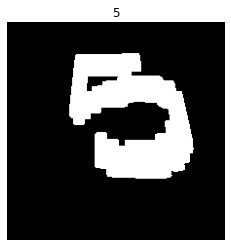

In [43]:
device = "cpu"

model = model.to(device)

idx = 9

val_input = val_features[idx]
imshow(val_input, title=val_labels[idx].item())
val_input = val_input[None, :]
val_input = val_input.to(device)
# print(val_input.shape)


output = model(val_input)
ps = torch.exp(output)

result = [str("{:.3f}".format(p)) for p in ps.detach().numpy()[0]]
print(result)


prediction_score, pred_label_idx = torch.topk(ps, 1)
pred_label_idx.squeeze_()

predicted_label = pred_label_idx.item()

correct = "Correct" if predicted_label == val_labels[idx].item() else "Wrong"
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')', correct)





IntegratedGradients


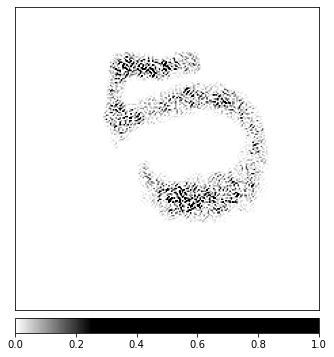

In [40]:
print("IntegratedGradients")

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(val_input, target=pred_label_idx, n_steps=200)

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(val_input.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

NoiseTunnel


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


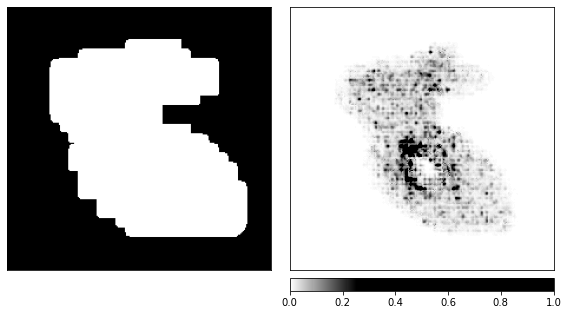

In [37]:
print("NoiseTunnel")
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(val_input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(val_input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

Occlusion 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


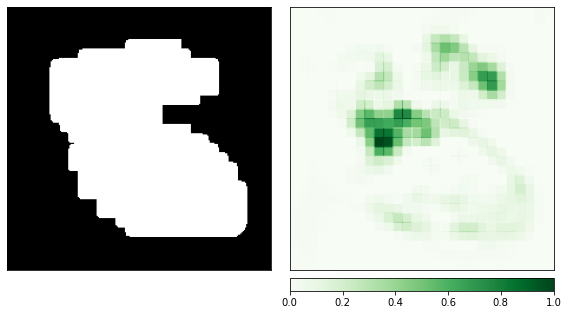

In [38]:
print("Occlusion 1")

occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(val_input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(val_input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )


Occlusion 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


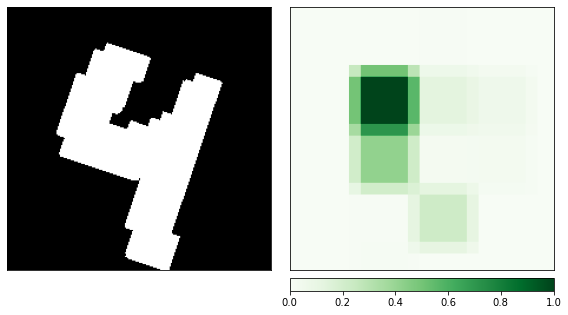

In [23]:
print("Occlusion 2")
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(val_input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(val_input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

In [61]:
print("Captum insight")

from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

model.to("cpu")

def baseline_func(input):
    return input * 0

def formatted_data_iter():
#     val_iterator = iter(val_dataloader)
    
    val_iterator = iter(DataLoader(val_dc, batch_size=24, shuffle=False, num_workers=2))
    while True:
        images, labels = next(val_iterator)
        labels = labels.argmax(dim=1)
        
        yield Batch(inputs=images, labels=labels)


normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
classes = [i for i in range(10)]

visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.exp(o),
    classes=classes,
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[],
        )
    ],
    dataset=formatted_data_iter(),
)

visualizer.render()

# from IPython.display import Image
# Image(filename='img/captum_insights.png')

Captum insight


CaptumInsights(insights_config={'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'methods': ['Deconvolution', 'Deep …

Output()

/tmp/ipykernel_19716/3151650763.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


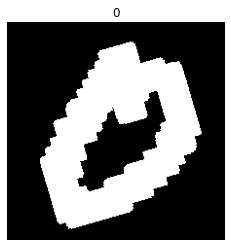

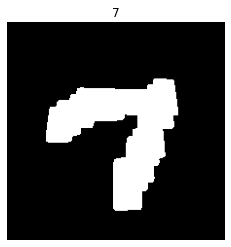

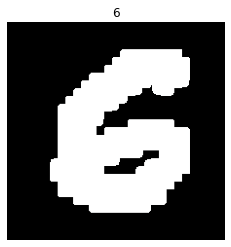

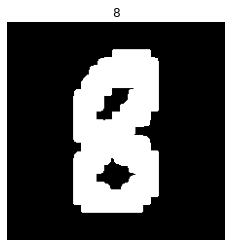

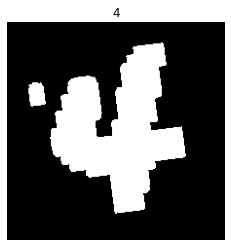

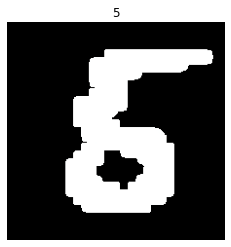

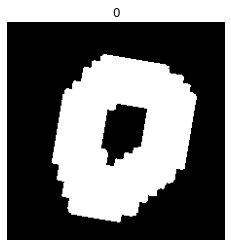

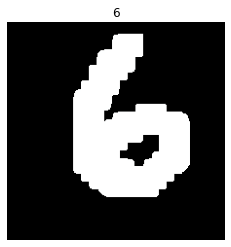

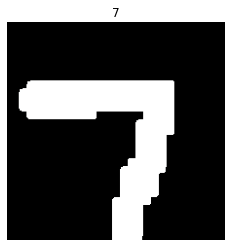

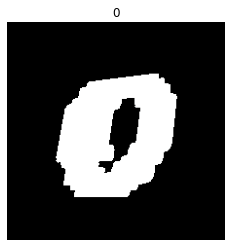

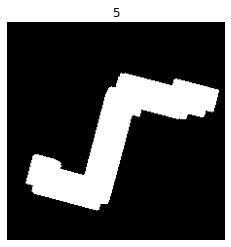

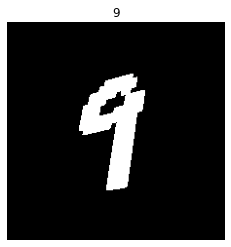

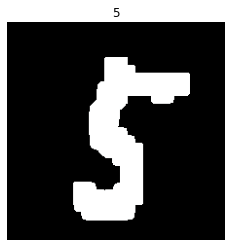

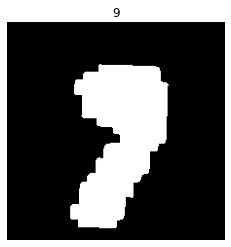

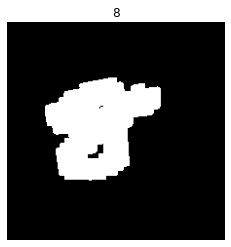

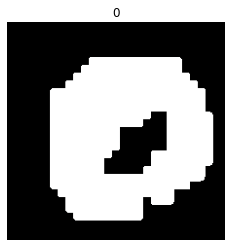

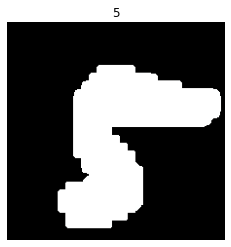

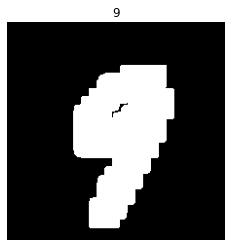

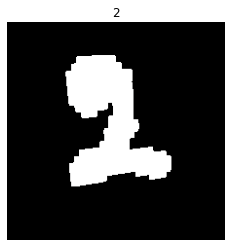

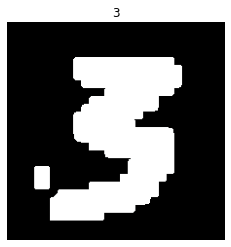

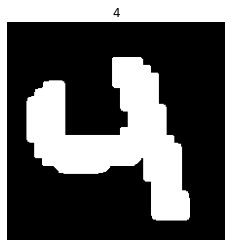

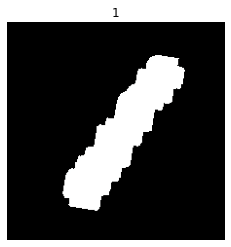

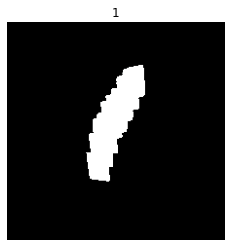

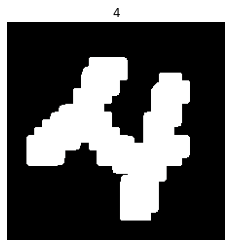

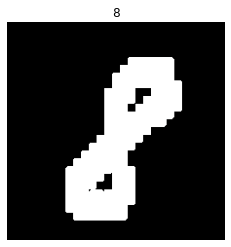

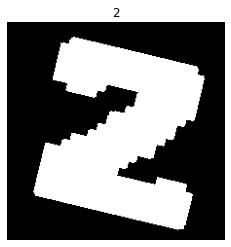

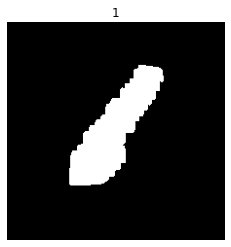

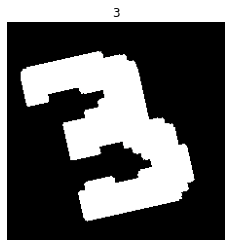

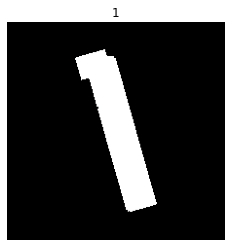

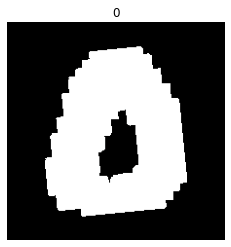

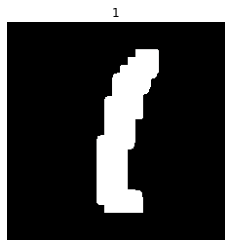

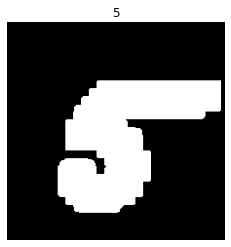

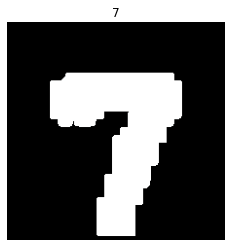

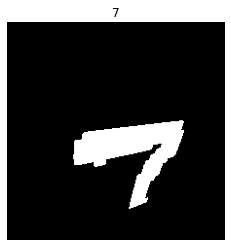

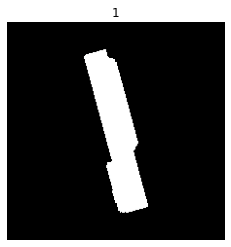

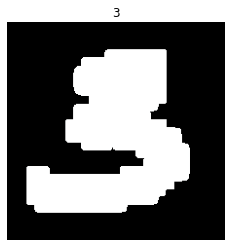

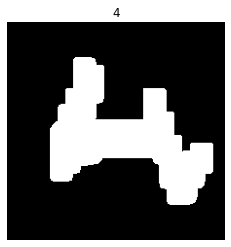

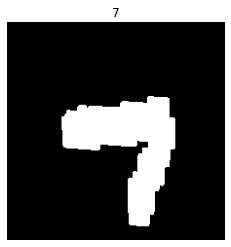

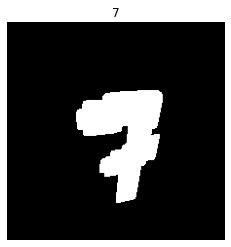

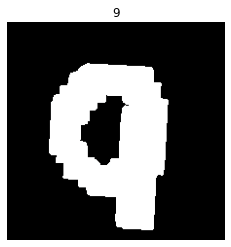

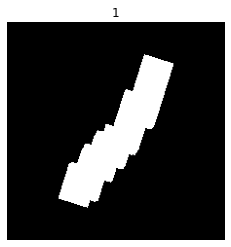

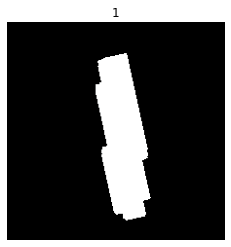

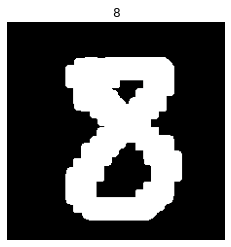

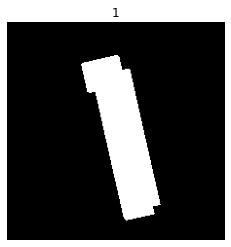

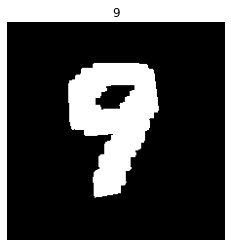

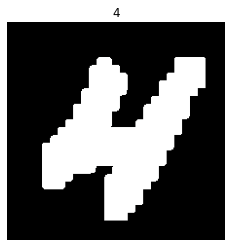

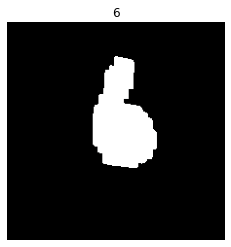

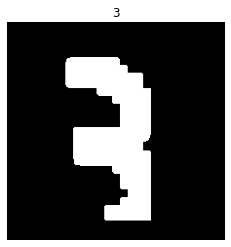

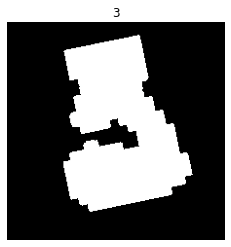

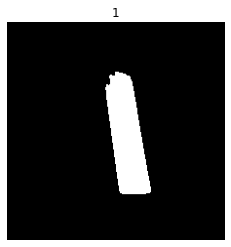

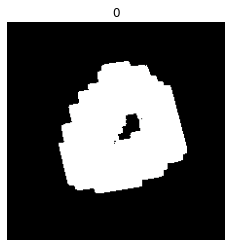

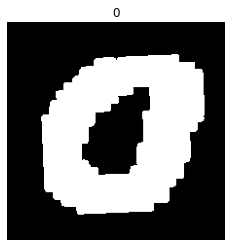

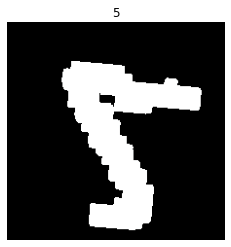

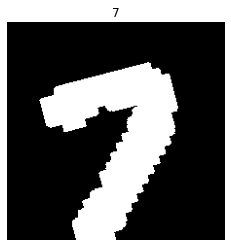

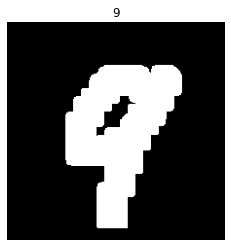

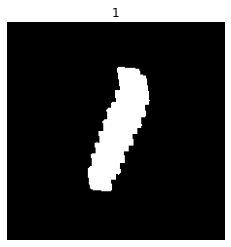

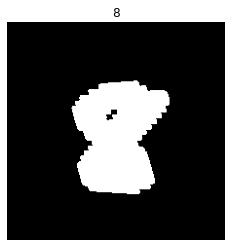

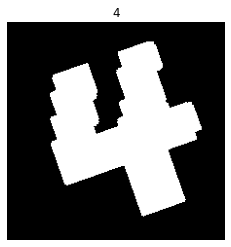

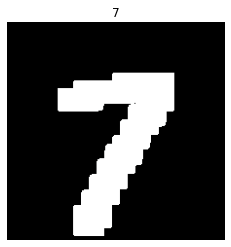

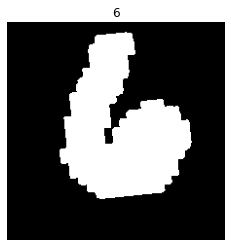

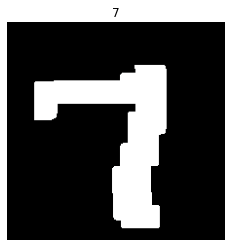

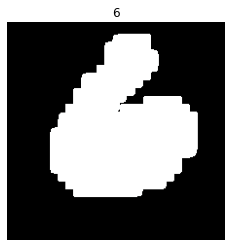

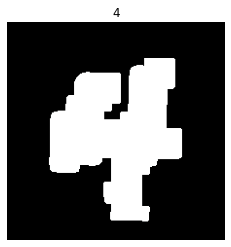

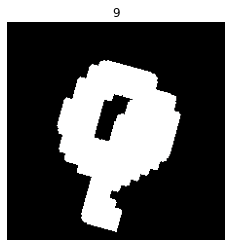

In [62]:
for img, label in zip(train_features, train_labels):
    idx += 1
    imshow(img, title=label.item())


In [31]:
# find better hyperparameters (lr)
# needs to visualize inner network representation
# needs to save losses, acc 
# needs to add train acc
# need to have cross error table
# need to add weight decay

In [18]:
eval_criterion = nn.CrossEntropyLoss()
eval_trainer = NetTrainer(model, eval_criterion, None)

eval_trainer.evaluate(val_dataloader)

eval_trainer.print_val_summary()


Train on:  cuda True
Val Accuracy of     0: 100% (229/229)
Val Accuracy of     1: 100% (233/233)
Val Accuracy of     2: 100% (187/187)
Val Accuracy of     3: 99% (209/210)
Val Accuracy of     4: 100% (212/212)
Val Accuracy of     5: 99% (177/178)
Val Accuracy of     6: 100% (178/178)
Val Accuracy of     7: 99% (204/205)
Val Accuracy of     8: 100% (166/166)
Val Accuracy of     9: 100% (202/202)


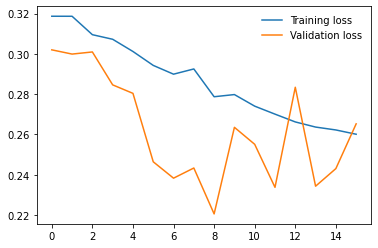

In [178]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [179]:
torch.save(model.state_dict(), './mnist_resnet50_26_1_.pt')

In [26]:
DataLoader?

In [27]:
DigitDataset??

In [59]:
def generate_sumbition(model, test_dataloader):
    sumbission = open("submission.csv", "w")
    sumbission.write("ImageId,Label\n")
    
    model.to("cpu")    
    with torch.no_grad():
        model.eval()
        i = 0
        for data in test_dataloader:
            
    
            output = model(data)

            ps = torch.exp(output)
            top_p, top_class = ps.topk(1, dim=1)
            
            for result in top_class:
                i += 1
                sumbission.write(str(i) + "," + str(result.item())  + "\n")
            
    sumbission.close()
    
test_dc = DigitDataset(data_dir, 'test.csv', transform=train_transform, is_train=False)
test_dataloader = DataLoader(test_dc, batch_size=batch_size, shuffle=False)

generate_sumbition(model, test_dataloader)


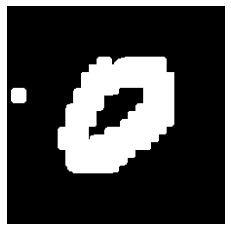

In [64]:
image = test_dc.__getitem__(3)
imshow(image);

In [65]:
"Submission result: 0.99450"

'Submission result: 0.99450'